# Neural Network

## Derivation of forward and back propagation

![Neural Network](NN.png)

Image from *Machine Learning* by **Zhihua Zhou**

Suppose that there are $d$ input neurons, $l$ output neurons and $q$ hidden-layer neurons.
Forward propagation:
$$
\begin{align}
\alpha_h &= \sum_{i=1}^d v_{ih}x_i \\
     b_h &= \text{Relu}(\alpha_h+\gamma_h) \\
 \beta_j &= \sum_{i=1}^q w_{hj}b_h \\
 \boldsymbol{\hat{y}} &= \boldsymbol{f}(\boldsymbol{\beta})
\end{align}
$$

where $\boldsymbol{f}$ denotes the softmax function of which $j$th component is
$$f_j(\boldsymbol{\beta}) = \frac{e^{\beta_j}}{\sum_{k=1}^l e^{\beta_k}}$$


We define the categorical loss for $k$th example:
$$E_k=-\sum_{j=1}^l y_j^k \log(\hat{y}_j^k) = -\log(\hat{y}^k_{p_k})$$
where $y_j^k$ is the one-hot vector for $p_k$, the true classification for $k$th example.

The total empirical loss is ($m$ training examples):
$$E = \sum_{k=1}^m E_k$$

Let's now derive the back propagation.

We denote the learning rate $\eta$.

Note that for **Relu** function the devirative is 1 when the input variable is positive, 0 when negative and not defined when input is 0. For simplicity, we will treat the derivative at input 0 to be zero.

For **softmax** function $\boldsymbol f (\boldsymbol t)$ we have:
$$
\frac {\partial f_j} {\partial t_i} = f_j\cdot(\delta_{ij} - f_i)
$$

(Too much pain typesetting math so I wrote them out)

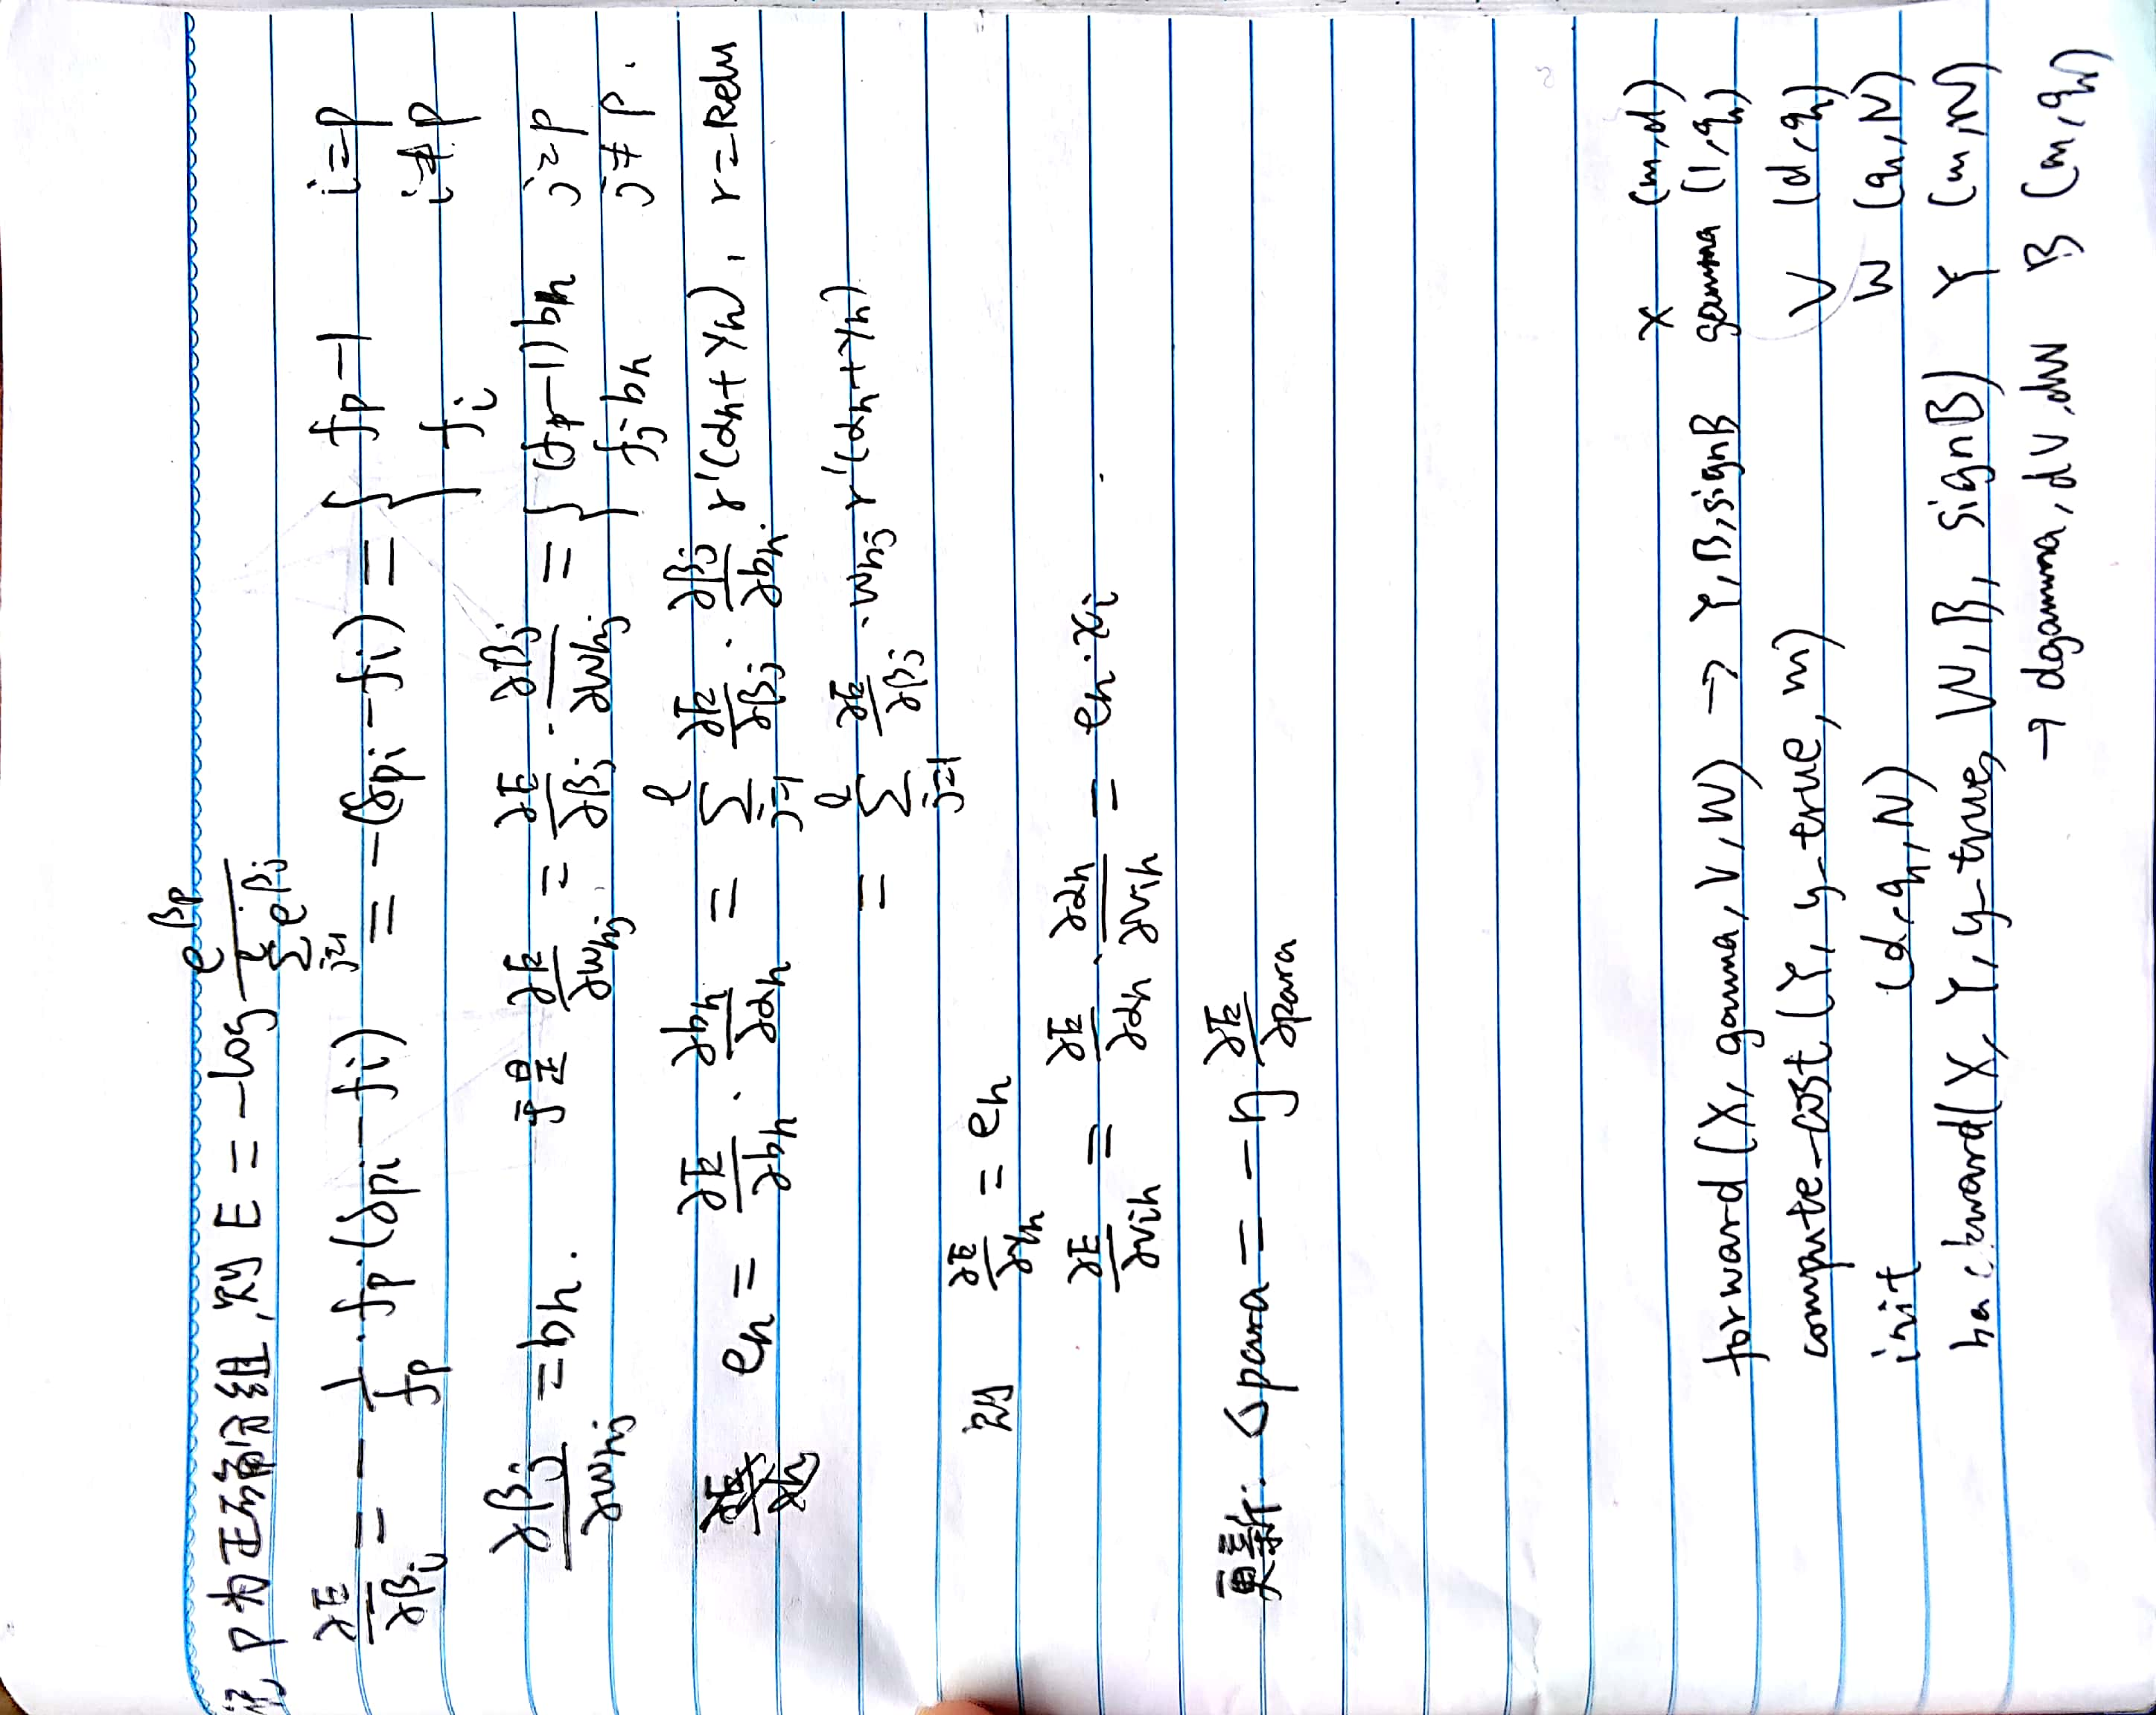

## Implement NN

In [7]:
import numpy as np

In [28]:
def softmax(y):
    y_exp = np.exp(y)
    return y_exp / np.sum(y_exp, axis=1, keepdims=True)

test_softmax_y = np.array([[1, 1, 1],
                           [1, 0, 1]])
softmax(test_softmax_y)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.4223188 , 0.1553624 , 0.4223188 ]])

In [20]:
def relu(x):
    return (x > 0) * x

# test_relu_x = np.array([[1], [0], [-3], [2]])
# relu(test_relu_x)

array([[1],
       [0],
       [0],
       [2]])

In [52]:
def forward(X, gamma, V, W):
    """Forward propagation.
    
    Args:
        X: feature vector, shape (m, d) m examples * d dimension
        gamma: bias term in the hidden layer, shape (1, q)
        V: weights linking input to hidden layer, shape (d, q)
        W: weights linking hidden layer to output layer, shape (q, N)
        
    Returns:
        Y: output vector, shape (m, N)
        B: hidden layer output, shape (m, q)
        signB: sign of B, shape (m, q) [Save for backprop computation]
    """
    alpha = np.dot(X, V)
    B = alpha + gamma
    
    # apply relu to B
    signB = B > 0
    B = signB * B
    
    beta = np.dot(B, W)
    Y = softmax(beta)
    
    return Y, B, signB

In [53]:
def compute_cost(Y, y_true, m):
    """Compute the cross-entroppy loss
    
    Args:
        Y: output from forward, shape (m, N)
        y_true: ground truth labels, shape (m, )
    
    Returns:
        (average) cost
    """
    
    Y_select = [Y[i, j] for i, j in enumerate(y_true)]
    return -np.sum(np.log(Y_select)) / m

In [42]:
# Y = np.array([[1/2, 1/2, 0],
#               [1/3, 1/3, 1/3],
#               [0, 1, 0]])
# y_true = [0, 2, 1]

# compute_cost(Y, y_true, 3)

0.5972531564093516

In [54]:
def initialize_parameters(d, q, N):
    """ Initialize parameters (gamma, V, W) """
    gamma = np.zeros((1, q))
    V = np.random.randn(d, q) * .01
    W = np.random.randn(q, N) * .01
    return gamma, V, W

In [55]:
def backward(X, Y, y_true, W, B, signB):
    """Compute the gradient using backprop
    
    Args:
        X: input, shape (m, d)
        Y: output from forward, shape (m, N)
        y_true: ground truth labels, shape (m, )
        W: weights linking hidden layer to output layer, shape (q, N)
        B: hidden layer output, shape (m, q)
        signB: sign of B, shape (m, q)
    
    Returns:
        dgamma, dV, dW
    """
    m = X.shape[0]
    G = np.copy(Y)
    # compute G (partial derivative to beta)
    for i, j in enumerate(y_true):
        G[i, j] -= 1
    dW = np.dot(B.T, G) / m
    
    E = np.dot(G, W.T) * signB
    dgamma = np.mean(E, axis=0, keepdims=True)
    dV = np.dot(X.T, E) / m
    
    return dgamma, dV, dW
    

In [70]:
def numerical_grad(X, Y, y_true, gamma, V, W, delta=0.0001):
    m, d = X.shape
    q = gamma.shape[1]
    N = Y.shape[1]
    cost = compute_cost(Y, y_true, m)
    dgamma = np.zeros((1, q))
    dV = np.zeros((d, q))
    dW = np.zeros((q, N))z
    
    # compute dgamma
    for i in range(q):
        gamma[0, i] += delta
        Y_temp, _, _ = forward(X, gamma, V, W)
        dgamma[0, i] = compute_cost(Y_temp, y_true, m)
        # reset
        gamma[0, i] -= delta
    dgamma = (dgamma - cost) / delta
    
    # compute dV
    for i in range(d):
        for j in range(q):
            V[i, j] += delta
            Y_temp, _, _ = forward(X, gamma, V, W)
            dV[i, j] = compute_cost(Y_temp, y_true, m)
            # reset
            V[i, j] -= delta
    dV = (dV - cost) / delta
    
    # compute dW
    for i in range(q):
        for j in range(N):
            W[i, j] += delta
            Y_temp, _, _ = forward(X, gamma, V, W)
            dW[i, j] = compute_cost(Y_temp, y_true, m)
            # reset
            W[i, j] -= delta
    dW = (dW - cost) / delta
    
    return dgamma, dV, dW

In [72]:
d = 5; N = 3; q = 4; m = 10
gamma, V, W = initialize_parameters(d, q, N)
X = np.random.randn(m, d)
y_true = np.random.randint(N, size=m)

Y, B, signB = forward(X, gamma, V, W)
cost = compute_cost(Y, y_true, m)
print(cost)

dgamma, dV, dW = backward(X, Y, y_true, W, B, signB)
ndgamma, ndV, ndW = numerical_grad(X, Y, y_true, gamma, V, W, delta=0.00001)

%precision 4
print(dgamma)
print(ndgamma)
print()
print(dV)
print(ndV)
print()
print(dW)
print(ndW)

1.0987194447181616
[[-0.0003 -0.0003  0.0029  0.0036]]
[[-0.0003 -0.0003  0.0029  0.0036]]

[[-6.7752e-04 -1.3520e-05  9.8901e-04  1.2336e-03]
 [ 7.0747e-04  2.7090e-05 -3.0311e-04 -3.7808e-04]
 [-5.4533e-04 -8.2802e-04  1.3918e-04  1.7364e-04]
 [-8.4260e-04  1.2283e-03  2.8000e-03  3.4924e-03]
 [ 3.4512e-04 -4.0071e-03 -2.1871e-03 -2.7279e-03]]
[[-6.7752e-04 -1.3520e-05  9.8901e-04  1.2336e-03]
 [ 7.0747e-04  2.7091e-05 -3.0311e-04 -3.7808e-04]
 [-5.4533e-04 -8.2802e-04  1.3918e-04  1.7364e-04]
 [-8.4260e-04  1.2283e-03  2.8000e-03  3.4924e-03]
 [ 3.4512e-04 -4.0071e-03 -2.1871e-03 -2.7279e-03]]

[[-0.0024  0.0008  0.0017]
 [ 0.0005 -0.0023  0.0019]
 [-0.0044  0.0022  0.0022]
 [-0.0039  0.0019  0.0019]]
[[-0.0024  0.0008  0.0017]
 [ 0.0005 -0.0023  0.0019]
 [-0.0044  0.0022  0.0022]
 [-0.0039  0.0019  0.0019]]


In [120]:
# a = np.array([[1, 2], [3, 4], [5, 6]])
# ind = np.random.permutation(3)
# a[ind]

array([[1, 2],
       [5, 6],
       [3, 4]])

In [134]:
for a in range(0, 7, 3):
    print(a)

0
3
6


In [137]:
def train(X_train, y_train, q, N, lr=0.01, epochs=10, shuffle=True, batch_size=None, print_cost=True, validate=True, X_test=None, y_test=None):
    m, d = X.shape
    hist = [None] * epochs
    gamma, V, W = initialize_parameters(d, q, N)
    if batch_size is None:
        batch_size = m
    
    for i in range(epochs):
        if shuffle:
                ind = np.random.permutation(m)
                XX = X_train[ind]
                yy = Y_train[ind]
        else:
            XX = X_train
            yy = Y_train
        for start in range(0, m - batch_size + 1, batch_size):
            # select batch
            X = XX[start:start+batch_size]
            y = yy[start:start+batch_size]
            
            Y, B, signB = forward(X, gamma, V, W)
            dgamma, dV, dW = backward(X, Y, y, W, B, signB)

            # update parameters
            gamma = gamma - lr * dgamma
            V = V - lr * dV
            W = W - lr * dW
        
        if print_cost and i % 100 == 0:
            Y, B, signB = forward(X_train, gamma, V, W)
            cost = compute_cost(Y, y_train, m)
            hist[i] = cost
            print("Cost after iteration %i: %f" % (i, cost))
            if validate:
                test(X_test, y_test, gamma, V, W)
        
    return gamma, V, W, hist

In [110]:
def predict(X, gamma, V, W):
    """
    Predict using MAP principle
    """
    Y, _, _ = forward(X, gamma, V, W)
    return np.argmax(Y, axis=1)

In [111]:
def test(X, y_true, gamma, V, W):
    y = predict(X, gamma, V, W)
    acc = np.mean(y == y_true)
    print('Testing accuracy: %.2f' % acc)

## Load MNIST data

In [138]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [74]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [83]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


1


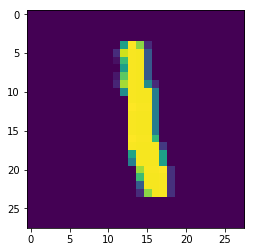

In [75]:
import matplotlib.pyplot as plt
plt.imshow(x_train[6,:,:])
print(y_train[6])

In [142]:
X_train = x_train.reshape((x_train.shape[0], -1))
X_test = x_test.reshape((x_test.shape[0], -1))

## Training and Testing

In [117]:
gamma, V, W, hist = train(X_train, y_train, q=20, N=10, lr=0.1, epochs=2000, X_test=X_test, y_test=y_test)

Cost after iteration 0: 2.302714
Testing accuracy: 0.12
Cost after iteration 100: 1.435185
Testing accuracy: 0.66
Cost after iteration 200: 0.609442
Testing accuracy: 0.84
Cost after iteration 300: 0.462525
Testing accuracy: 0.88
Cost after iteration 400: 0.404023
Testing accuracy: 0.89
Cost after iteration 500: 0.370826
Testing accuracy: 0.90
Cost after iteration 600: 0.348090
Testing accuracy: 0.90
Cost after iteration 700: 0.330892
Testing accuracy: 0.91
Cost after iteration 800: 0.317097
Testing accuracy: 0.91
Cost after iteration 900: 0.305671
Testing accuracy: 0.91
Cost after iteration 1000: 0.295901
Testing accuracy: 0.92
Cost after iteration 1100: 0.287312
Testing accuracy: 0.92
Cost after iteration 1200: 0.279573
Testing accuracy: 0.92
Cost after iteration 1300: 0.272523
Testing accuracy: 0.92


KeyboardInterrupt: 

In [136]:
# mini-batch
gamma, V, W, hist = train(X_train, y_train, q=20, N=10, lr=0.1, batch_size=500, epochs=1000, X_test=X_test, y_test=y_test)

Cost after iteration 0: 2.302878
Testing accuracy: 0.10
Cost after iteration 100: 1.531199
Testing accuracy: 0.67
Cost after iteration 200: 0.629382
Testing accuracy: 0.83
Cost after iteration 300: 0.472109
Testing accuracy: 0.87
Cost after iteration 400: 0.405133
Testing accuracy: 0.89
Cost after iteration 500: 0.369413
Testing accuracy: 0.90
Cost after iteration 600: 0.347045
Testing accuracy: 0.91
Cost after iteration 700: 0.331247
Testing accuracy: 0.91
Cost after iteration 800: 0.319302
Testing accuracy: 0.91
Cost after iteration 900: 0.309811
Testing accuracy: 0.92


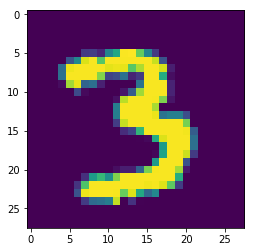

In [146]:
plt.imshow(x_test[500])

In [147]:
predict(X_test[500], gamma, V, W)

array([3])